## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [38]:
B_homes

,longitude,latitude,country,user
user_id,,,,
18790,-116.203451,43.613500,US,18790
50434,-2.966667,56.500000,GB,50434
52196,145.133333,-37.916667,AU,52196
26515,139.550000,35.683333,JP,26515
25999,139.678110,35.640909,JP,25999
...,...,...,...,...
41351,2.173334,41.417957,ES,41351
45722,138.000000,36.000000,JP,45722
39982,-94.838368,29.287577,US,39982


In [9]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

In [10]:
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

In [11]:
B_homes.head()

,longitude,latitude,country,user
user_id,,,,
0,-105.009140,39.756108,US,0
1,-122.353819,37.581821,US,1
2,-105.041977,39.771737,US,2
3,-122.424280,37.765768,US,3
4,24.937299,60.173985,FI,4


#### Load cities

In [28]:
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)
cities = cities.drop(columns = ['capital', 'admin_name'], axis = 1)

In [29]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82


#### Load edges

In [7]:
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


<AxesSubplot:xlabel='population', ylabel='area'>

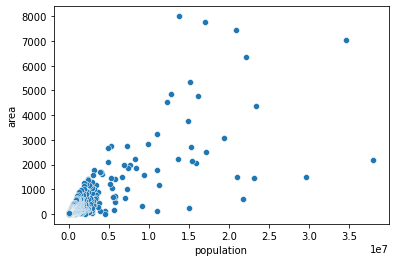

In [30]:
# Inspect data
cities['density'] = cities['population'] / cities['area']
plt_cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]
sns.scatterplot(data=plt_cities, x='population', y="area")

In [31]:
# 0. Estimate the missing areas for cities
n_cities = cities[cities.isnull().any(axis=1)]
n_cities = n_cities[n_cities['population'] > 50000]


# Cannot predict for unknown population
n_cities = n_cities[~n_cities['population'].isnull()]

# Drop missing values for prediction
cities = cities[cities['population'] > 50000]
cities = cities[~cities['area'].isnull()]

In [32]:
# 1. Construct a linear model to estimate the missing areas
X = cities['population'].values.reshape(-1, 1)
y = cities['area'].values
reg = LinearRegression().fit(X, y)

# Predict the missing areas
pred_area = reg.predict(n_cities['population'].values.reshape(-1, 1))
n_cities['area'] = pred_area

# Merge city data
cities = cities.append(n_cities)

# 2. Calculate population density again for all data
cities['density'] = cities['population'] / cities['area']

In [33]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

In [34]:
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.070000,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.500000,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.000000,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.000000,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.820000,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...,...,...,...
11190,Borovichi,Borovichi,58.4000,33.9167,Russia,RU,RUS,50144.0,1643059892,5037.289024,9.954561,40.042713
11193,Slonim,Slonim,53.0833,25.3167,Belarus,BY,BLR,50100.0,1112619287,5037.267292,9.945869,40.042627
11194,Roslavl,Roslavl,53.9492,32.8569,Russia,RU,RUS,50112.0,1643356591,5037.273219,9.948239,40.042651
11195,Gogrial,Gogrial,8.5337,28.1167,South Sudan,SS,SSD,50065.0,1728342889,5037.250005,9.938955,40.042558


In [13]:
# 4. Drop cities with # inhabitants < 50.000 and population density < 1500
#cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]
#cities = cities.drop_duplicates()

In [27]:
# Save cities dataframe
cities.to_pickle("cities.pickle")

### Does user live in rural or urban area?

  for each country:
  
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes



In [35]:
# Take a subset for now
B_homes = B_homes.sample(4000, random_state=1)
G_homes = G_homes.sample(4000, random_state=1)

In [36]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')

In [ ]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)

In [ ]:
B_merge.head()

In [ ]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [ ]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [ ]:
B_homes.head()
G_homes.head()

In [35]:
# Save intermediate results
# Save home locations
B_merge.to_pickle("B_merge_.pickle")
G_merge.to_pickle("G_merge_.pickle")

### Calculate # friends per user, group by rural/city and compare amount of friends


In [ ]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [ ]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [23]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
18790,-116.203451,43.613500,US,18790,True,1
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10


### Compare amount of friends for urban/ rural users

In [ ]:
B_homes.groupby('lives_urban')['#_friends'].describe()

In [ ]:
G_homes.groupby('lives_urban')['#_friends'].describe()

In [ ]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural', hist=False)
sns.distplot(B_urban['#_friends'], label='urban', hist=False)
plt.legend();

In [ ]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(G_rural['#_friends'], label='rural', hist=False)
sns.distplot(G_urban['#_friends'], label='urban', hist=False)
plt.legend();

### Statistical Test to investigate significant effect

We will perform a poisson-test to inspect whether the two samples stem from the same possion distribution. We assume $\alpha = 0.05$.

Check assumptions:
1. Underlying distribution is a poisson
2. estimate the four rates, $\lambda_{bk-urban}, \lambda_{bk-rural},\lambda_{gw-urban},\lambda_{gw-rural}$

All four distributions seems to be a bit more skewed than expected for a poisson distribution.


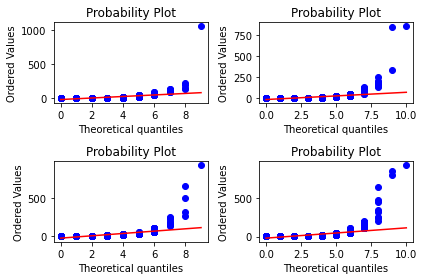

In [55]:
# 2. Inspect the distribution of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

data = B_urban['#_friends']
stats.probplot(B_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax1)
stats.probplot(B_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax2)
stats.probplot(G_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax3)
stats.probplot(G_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax4)
fig.tight_layout()

print("All four distributions seems to be a bit more skewed than expected for a poisson distribution.")

In [36]:
sample1_k, sample1_n = B_urban['#_friends'].mean(), len(B_urban)
sample2_k, sample2_n = B_rural['#_friends'].mean(), len(B_rural)
poiss_p_1 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_1,6)}.")

Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.047074.


In [34]:
sample1_k, sample1_n = G_urban['#_friends'].mean(), len(G_urban)
sample2_k, sample2_n = G_rural['#_friends'].mean(), len(G_rural)
poiss_p_2 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_2,6)}.")

Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.042888.


TODO 
Do directional hypothesis

## OLD

In [37]:
# 1. Check for equal variances:
# The Levene test tests the null hypothesis that all input samples are from populations with equal variances.

#_, p1 = levene(B_urban['#_friends'], B_rural['#_friends'])
#_, p2 = levene(G_urban['#_friends'], G_rural['#_friends'])

#print(" p-value Brightkite:", p1, "\n", "p-value Gowalla:", p2, "\n")
#print("We reject the null hypothesis that all input samples are from populations with equal variance for the Brightkite data, but not for the Gowalla data.")

In [31]:
stats.ttest_ind(B_urban['#_friends'],B_rural['#_friends'], equal_var = False)

Ttest_indResult(statistic=1.8449063677581616, pvalue=0.06521400342208286)

In [32]:
##  Perform the t-test
stats.ttest_ind(G_urban['#_friends'],G_rural['#_friends'], equal_var = True)

Ttest_indResult(statistic=0.6912586471195667, pvalue=0.4894449533512313)